*Note: This file is still a work in progress*

## 1. Data Exploration



In [1]:
import torch
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.data_utils import get_final_ds

dataset = get_final_ds()


Data exists at path: /Users/yassinkina/Desktop/Github/portfolio/review_sentiment_analysis/data/datasets, loading data...


Ensure there are no empty values within each of the data splits. We will focus most of our analysis on `df_train`, but it is still crucial to not assume that our data is clean.

In [3]:
df_train = pd.DataFrame.from_dict(dataset["train"])
df_val = pd.DataFrame.from_dict(dataset["validation"])
df_test = pd.DataFrame.from_dict(dataset["test"])

print(df_train.isna().values.any())
print(df_val.isna().values.any())
print(df_test.isna().values.any())


False
False
False


Here we can see that more than half of the reviews are 5 stars and that 1, 2, and 3 star ratings make up less than 25% of the data.

In [4]:
df_train.describe()

,rating,timestamp,helpful_vote
count,10000.000000,1.000000e+04,10000.000000
mean,4.108500,1.552776e+12,1.017000
std,1.315941,7.819591e+10,5.833996
min,1.000000,1.050088e+12,0.000000
25%,4.000000,1.495931e+12,0.000000
50%,5.000000,1.570662e+12,0.000000
75%,5.000000,1.612363e+12,1.000000
max,5.000000,1.679133e+12,430.000000


### Skewed Data
With a bar graph we can even more clearly see how skewed the data is. We can plot each of the dataset splits to ensure that every label is represented in each split.

In [5]:
import matplotlib.pyplot as plt

def plot_star_rating_counts(df, title):
    counts_per_rating = df["rating"].value_counts().sort_index()
    color = ["blue" if title == "Train" else "orange" if title == "Validation" else "green"]
    plt.bar(x=counts_per_rating.index, height=counts_per_rating.values, color=color)
    plt.xlabel("Star Rating")
    plt.ylabel("Number of Reviews")
    plt.title(f"Number of Customer Reviews per Star Rating: {title} ")
    

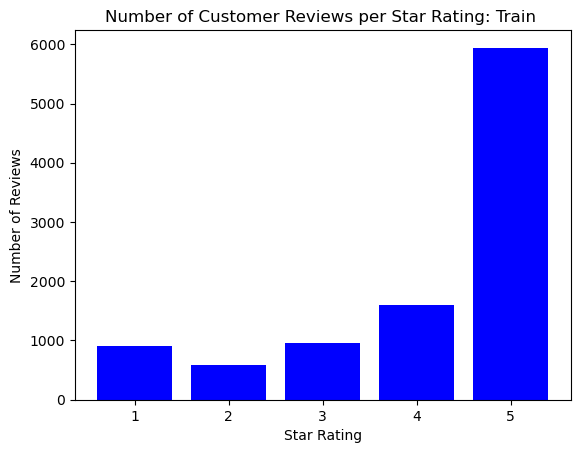

In [6]:
plot_star_rating_counts(df_train, "Train")

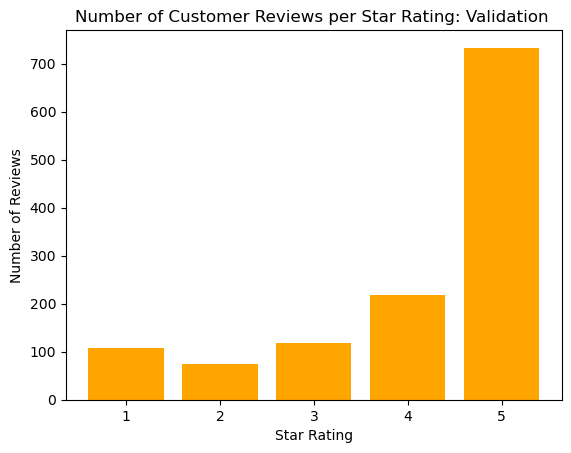

In [7]:
plot_star_rating_counts(df_val, "Validation")

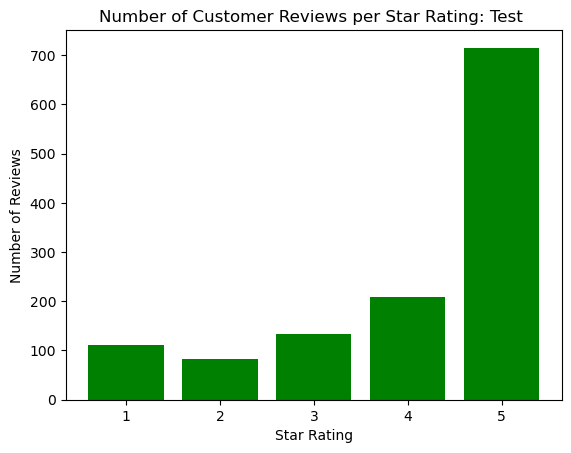

In [8]:
plot_star_rating_counts(df_test, "Test")

## 2. Review Length Analysis
Understanding the length of reviews is crucial for selecting model parameters (like max sequence length).

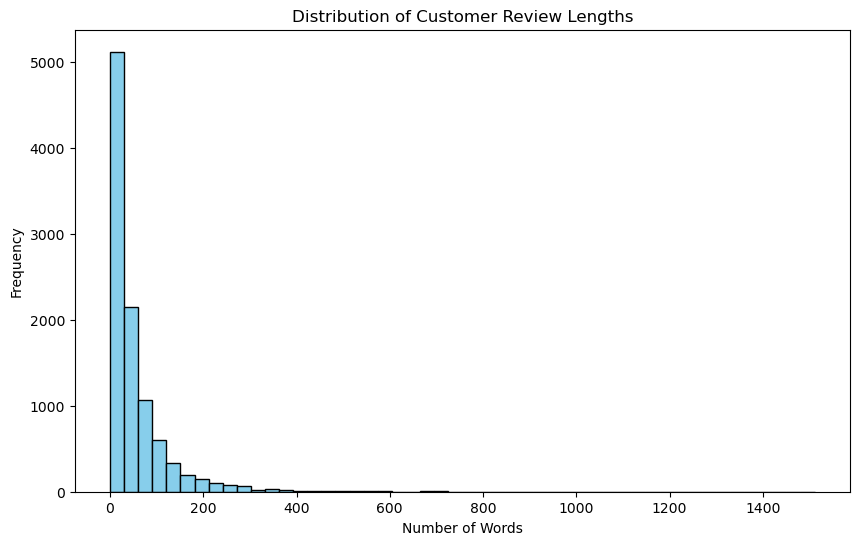

count    10000.000000
mean        53.165600
std         73.754774
min          0.000000
25%         11.000000
50%         29.000000
75%         65.000000
max       1511.000000
Name: review_length, dtype: float64


In [9]:
# Calculate review length (number of words)
df_train['review_length'] = df_train['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
plt.hist(df_train['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Customer Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

print(df_train['review_length'].describe())

## 3. Temporal Analysis
Checking how the number of reviews changes over time.

/var/folders/24/5y8ykfh1335dq604_v6rws5c0000gn/T/ipykernel_37746/3872363991.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  reviews_over_time = df_train.set_index('date').resample('M').size()


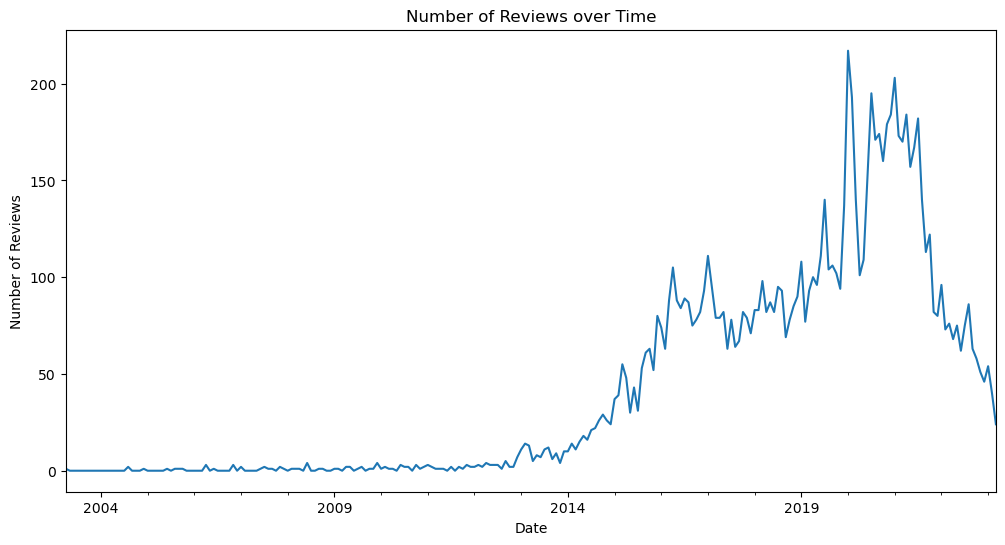

In [10]:
df_train['date'] = pd.to_datetime(df_train['timestamp'], unit='ms')
reviews_over_time = df_train.set_index('date').resample('M').size()

plt.figure(figsize=(12, 6))
reviews_over_time.plot()
plt.title('Number of Reviews over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

## 4. Initial Conclusions
Given that the number of 5 star reviews is significantly higher than the other star ratings, we must take this into account when evaluating our model's performance. More specifically, `Accuracy` will not be a useful metric because the skewed 5 star ratings may cause the model to learn to guess 5 stars 100% of the time, which would provide us with a misleading and inaccurate understanding as to how well the model actually peforms. 

To mitigate this, we will use `F1 Score` as the primary metric of our model's performance. Given that there are only 5 classes (each of the star ratings), a Confusion Matrix will be an effective way to visualize how well the model actually performs, so we will discuss `Precision` and `Recall` as well.

## 

## Model Performance


### Base Model Performance


In [11]:
import sys
import os
import json
sys.path.append(os.path.abspath(os.path.join('..')))

from transformers import Trainer, AutoModelForSequenceClassification, DataCollatorWithPadding
from src.engine import get_training_arguments, compute_metrics
from src.tokenize import tokenize
from src.data_utils import get_final_ds

In [12]:
base_model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=5,
    problem_type="single_label_classification"
)
print(base_model.training)


dataset = get_final_ds()
tokenized_dataset, tokenizer = tokenize(dataset)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = get_training_arguments()

# trainer for base predictions
base_trainer = Trainer(
    model=base_model,
    args=training_args,
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    
)

base_metrics = base_trainer.evaluate()
print(base_metrics)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


False
Data exists at path: /Users/yassinkina/Desktop/Github/portfolio/review_sentiment_analysis/data/datasets, loading data...
Tokenzing dataset...


wandb: Currently logged in as: yassinkina (yassinbkina) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 1.6421632766723633, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.0888, 'eval_f1': 0.014484643644379134, 'eval_runtime': 29.435, 'eval_samples_per_second': 42.466, 'eval_steps_per_second': 5.334}


Get metrics from fine-tuned model

In [13]:
ft_model_path = "../models/checkpoint-200/trainer_state.json"

with open(ft_model_path, "r") as f:
    history = json.load(f)["log_history"]
    
ft_model_f1 = [x["eval_f1"] for x in history if "eval_f1" in x ]
ft_model_accuracy = [x["eval_accuracy"] for x in history if "eval_accuracy" in x ]


Compare F1 and Accuracy of roberta-base and fine-tuned model

In [14]:

def plot_metric(models, base_metric, ft_model_metric, metric="f1"):
    plt.figure()
    bars = plt.bar(models, [base_metric, ft_model_metric])
    if metric == "f1":
        plt.title("F1 Comparison")
        plt.ylabel("F1")
        plt.xlabel("Model")
    else:
        plt.title("Accuracy Comparison")
        plt.ylabel("Accuracy")
        plt.xlabel("Model")

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height / 2,
            f"{100 * height:.2f}%",
            ha="center",
            va="center",
            fontsize=12,
            fontweight="bold",
            color="white"
        )

    plt.show()

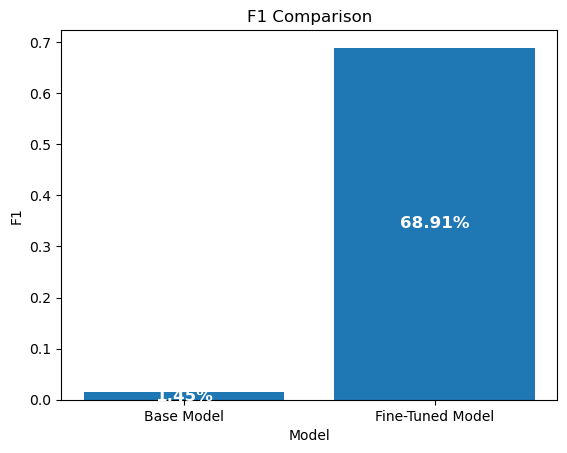

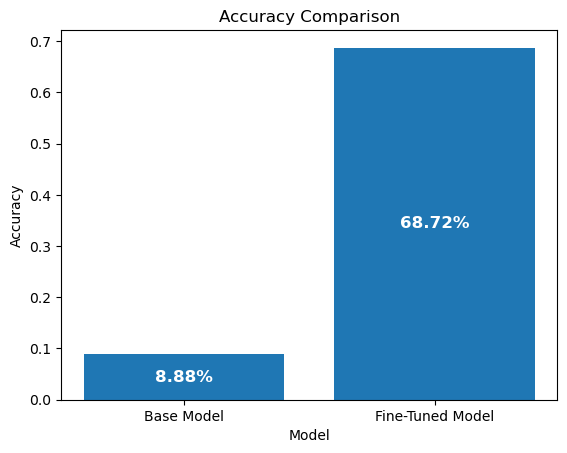

In [15]:
import matplotlib.pyplot as plt

# Get final fine-tuned metrics
ft_final_accuracy = ft_model_accuracy[-1]
ft_final_f1 = ft_model_f1[-1]

base_accuracy = base_metrics["eval_accuracy"]
base_f1 = base_metrics["eval_f1"]

models = ["Base Model", "Fine-Tuned Model"]

# Plot F1 and Accuracy
plot_metric(models, base_f1, ft_final_f1,metric="f1")
plot_metric(models, base_accuracy, ft_final_accuracy,metric="accuracy")



Confusion Matrix


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_normalized_comparison(y_true, y_pred_base, y_pred_finetuned):
    """
    Generates and saves a side-by-side confusion matrix comparison.

    Args:
        y_true (array-like): Ground truth (correct) target values.
        y_pred_base (array-like): Estimated targets from the baseline model.
        y_pred_finetuned (array-like): Estimated targets from the fine-tuned model.

    Returns:
        None: Displays and saves the plot.
    """
    # raw calculations
    cm_base = confusion_matrix(y_true, y_pred_base)
    cm_tuned = confusion_matrix(y_true, y_pred_finetuned)

    # normalized matrices calculations
    cmn_base = cm_base.astype('float') / cm_base.sum(axis=1)[:, np.newaxis]
    cmn_tuned = cm_tuned.astype('float') / cm_tuned.sum(axis=1)[:, np.newaxis]


    def get_labels(cm, cmn) ->np.ndarray:
        
        labels = []
        for i in range(cm.shape[0]):
            row = []
            for j in range(cm.shape[1]):
                # Format: Percentage \n (Raw Count)
                label = f"{cmn[i, j]:.0%}\n({cm[i, j]})"
                row.append(label)
            labels.append(row)
        return np.array(labels)

    labels_base = get_labels(cm_base, cmn_base)
    labels_tuned = get_labels(cm_tuned, cmn_tuned)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    class_names = ["1★", "2★", "3★", "4★", "5★"]

    # Plot Base
    sns.heatmap(cmn_base, annot=labels_base, fmt='', cmap='Reds', ax=axes[0],
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    axes[0].set_title('Baseline Model Normalized Confusion Matrix', fontsize=14, fontweight='bold')

    # Plot Fine-Tuned
    sns.heatmap(cmn_tuned, annot=labels_tuned, fmt='', cmap='Blues', ax=axes[1],
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    axes[1].set_title('Fine-Tuned Model Normalized Confusion Matrix', fontsize=14, fontweight='bold')

    for ax in axes:
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    plt.tight_layout()
    # plt.savefig("./assets/hybrid_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

Generating Base Model predictions...


/opt/miniconda3/envs/nlp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Generating Fine-Tuned predictions...


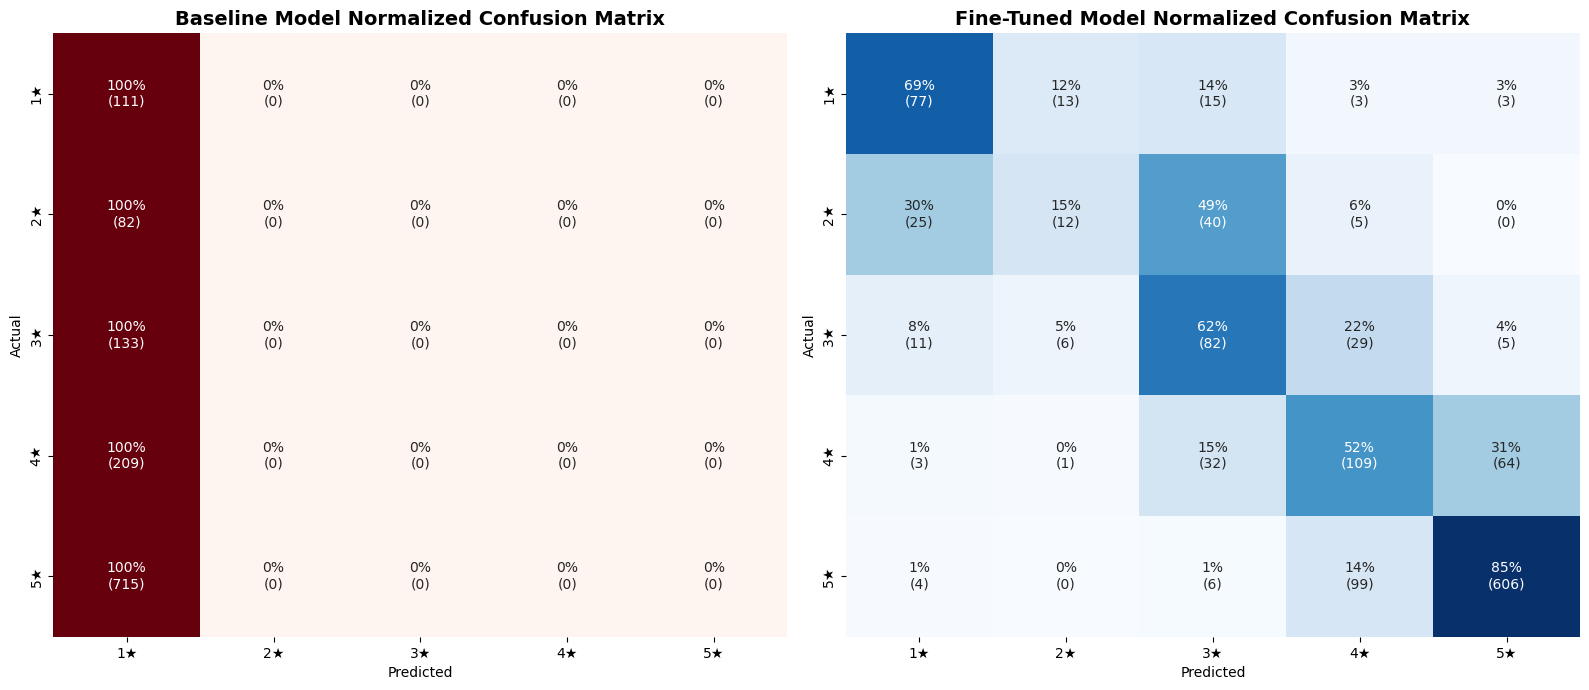

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoModelForSequenceClassification, Trainer

checkpoint = "../models/checkpoint-200"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=5,
                                                           problem_type="single_label_classification"
)
# Get predictions from base model
print("Generating Base Model predictions...")
base_trainer = Trainer(model=base_model, data_collator=data_collator)
base_output = base_trainer.predict(tokenized_dataset["test"])
y_pred_base = np.argmax(base_output.predictions, axis=1)


#get finetuned predictions
print("Generating Fine-Tuned predictions...")
ft_trainer = Trainer(model=model, data_collator=data_collator)
ft_output = ft_trainer.predict(tokenized_dataset["test"])
y_pred_finetuned = np.argmax(ft_output.predictions, axis=1)

y_true = base_output.label_ids

plot_normalized_comparison(y_true, y_pred_base, y_pred_finetuned)

Push models to Hugging Face

In [18]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
checkpoint = "../models/checkpoint-200"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=5,
                                                           problem_type="single_label_classification"
)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

model.push_to_hub("roberta-sentiment-analysis-ft")
tokenizer.push_to_hub("roberta-sentiment-analysis-ft")


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...0gn/T/tmpfhx5_qzd/model.safetensors:   0%|          | 8.91kB /  499MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yassinkina/roberta-sentiment-analysis-ft/commit/eb21b43aae755bf149855697123b919d3f24cd4b', commit_message='Upload tokenizer', commit_description='', oid='eb21b43aae755bf149855697123b919d3f24cd4b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yassinkina/roberta-sentiment-analysis-ft', endpoint='https://huggingface.co', repo_type='model', repo_id='yassinkina/roberta-sentiment-analysis-ft'), pr_revision=None, pr_num=None)